# VAE について学習
- https://data-analytics.fun/2022/01/22/pytorch-vae/

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
 
# PyTorch画像用
import torchvision
import torchvision.transforms as transforms
 
# 画像表示用
import matplotlib.pyplot as plt

In [3]:
batch_size = 128

# データセットの取得
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    # ToTensor関数の動きを理解しnumpyと相互変換できるようになる
    transform=transforms.ToTensor(),
    download=True,
)
# DataLoaderの作成
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [19]:
for test in train_loader:
    print(test)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [4]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    # PyTorch で全結合層を定義 線形結合
    self.fc = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_var = nn.Linear(hidden_dim, latent_dim)
  
  def forward(self, x):
    # ニューラルネットワークで事後分布の平均・分散を計算する
    h = torch.relu(self.fc(x))
    mu = self.fc_mu(h) # μ
    log_var = self.fc_var(h) # log σ^2
 
    # 潜在変数を求める
    ## 標準正規乱数を振る
    # 平均 0、分散 1 の正規分布からの乱数で満たさ れたものと同じサイズのテンソルを返します
    eps = torch.randn_like(torch.exp(log_var))
    ## 潜在変数の計算 μ + σ・ε
    z = mu + torch.exp(log_var / 2) * eps
    return mu, log_var, z

In [5]:
class Decoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(latent_dim, hidden_dim)
    self.fc_output = nn.Linear(hidden_dim, input_dim)
  
  def forward(self, z):
      h = torch.relu(self.fc(z))
      # 最後の全結合層の活性化関数はシグモイド関数として、0~1の値を返します。
      output = torch.sigmoid(self.fc_output(h))
      return output


In [6]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(input_dim, hidden_dim, latent_dim)
    
  def forward(self, x):
    mu, log_var, z = self.encoder(x) # エンコード
    x_decoded = self.decoder(z) # デコード
    return x_decoded, mu, log_var, z 

In [7]:
def loss_function(label, predict, mu, log_var):
  reconstruction_loss = F.binary_cross_entropy(predict, label, reduction='sum')
  # KLダイバージェンス項の計算
  kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  vae_loss = reconstruction_loss + kl_loss
  return vae_loss, reconstruction_loss, kl_loss

In [10]:
# 長田さんコード
def select_device():
    # “”"GPU もしくは CPU の選択“”"
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is selected as device!')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print('mps is selected as device!')
    else:
        device = torch.device('cpu')
        print('cpu....f')
    return device
device = select_device()

mps is selected as device!


In [11]:
image_size = 28 * 28
h_dim = 32
z_dim = 16
num_epochs = 10
learning_rate = 1e-3
 
model = VAE(image_size, h_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# 予測⇒損失の計算⇒パラメータの更新⇒損失の表示
losses = []
# PyTorchではmodel.train()やmodel.eval()によって、モデルのモードを切り替えますが
# これらのメソッドによってドロップアウトを行うか否かを自動で切り替えてくれるのは
# ドロップアウトクラス（torch.nn.Dropout）の方です。torch.nn.functional.dropoutの方は
# model.eval()などが働きません。
# 関数の引数でtorch.nn.functional.dropout(training=False)などとしなければならないのです。​
model.train()

for epoch in range(num_epochs):
  train_loss = 0
  # train_loaderが学習データ
  for i, (x, labels) in enumerate(train_loader):
    # 予測
    # view(-1, 指定したいサイズ数)
    x = x.to(device).view(-1, image_size).to(torch.float32)
    x_recon, mu, log_var, z = model(x)
    # 損失関数の計算
    loss, recon_loss, kl_loss = loss_function(x, x_recon, mu, log_var)
     
    # パラメータの更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    # 損失の表示
    if (i+1) % 10 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}, reconstruct loss: {recon_loss: 0.4f}, KL loss: {kl_loss: 0.4f}')
    losses.append(loss)

Epoch: 1, loss:  68246.7891, reconstruct loss:  68137.4922, KL loss:  109.2957
Epoch: 1, loss:  64762.3125, reconstruct loss:  64583.4023, KL loss:  178.9115
Epoch: 1, loss:  57676.3398, reconstruct loss:  56387.1172, KL loss:  1289.2239
Epoch: 1, loss:  47143.0625, reconstruct loss:  43229.8711, KL loss:  3913.1904
Epoch: 1, loss:  38560.1641, reconstruct loss:  34318.4805, KL loss:  4241.6846
Epoch: 1, loss:  34368.0586, reconstruct loss:  31318.9414, KL loss:  3049.1182
Epoch: 1, loss:  31968.4199, reconstruct loss:  29278.2227, KL loss:  2690.1968
Epoch: 1, loss:  31524.9258, reconstruct loss:  29040.0234, KL loss:  2484.9033
Epoch: 1, loss:  30196.3828, reconstruct loss:  27966.3359, KL loss:  2230.0474
Epoch: 1, loss:  29937.6621, reconstruct loss:  28023.0859, KL loss:  1914.5769
Epoch: 1, loss:  29682.1348, reconstruct loss:  27814.4668, KL loss:  1867.6685
Epoch: 1, loss:  29084.5820, reconstruct loss:  27289.1230, KL loss:  1795.4596
Epoch: 1, loss:  28992.4805, reconstruct l

In [13]:

def loss_function(label, predict, mu, log_var):
  reconstruction_loss = F.binary_cross_entropy(predict, label, reduction='sum')
  kl_loss = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  vae_loss = reconstruction_loss + kl_loss
  return vae_loss, reconstruction_loss, kl_loss

In [14]:
image_size = 28 * 28
h_dim = 32
z_dim = 16
num_epochs = 10
learning_rate = 1e-3
 
model = VAE(image_size, h_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
losses = []
model.train()
for epoch in range(num_epochs):
  train_loss = 0
  for i, (x, labels) in enumerate(train_loader):
    # 予測
    x = x.to(device).view(-1, image_size).to(torch.float32)

    # class VAE → return x_decoded, mu, log_var, z 
    x_recon, mu, log_var, z = model(x)
    # 損失関数の計算
    loss, recon_loss, kl_loss = loss_function(x, x_recon, mu, log_var)

    # パラメータの更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 損失の表示
    if (i+1) % 10 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}, reconstruct loss: {recon_loss: 0.4f}, KL loss: {kl_loss: 0.4f}')
    losses.append(loss)

Epoch: 1, loss:  67820.0938, reconstruct loss:  67718.9375, KL loss:  101.1570
Epoch: 1, loss:  63414.6250, reconstruct loss:  62852.0547, KL loss:  562.5718
Epoch: 1, loss:  54608.6719, reconstruct loss:  52324.1016, KL loss:  2284.5684
Epoch: 1, loss:  45038.5195, reconstruct loss:  40639.2422, KL loss:  4399.2764
Epoch: 1, loss:  37659.3516, reconstruct loss:  34108.9219, KL loss:  3550.4280
Epoch: 1, loss:  33651.3789, reconstruct loss:  30531.3398, KL loss:  3120.0405
Epoch: 1, loss:  32124.7930, reconstruct loss:  29278.3750, KL loss:  2846.4189
Epoch: 1, loss:  30383.2539, reconstruct loss:  27732.1875, KL loss:  2651.0659
Epoch: 1, loss:  30832.9980, reconstruct loss:  28858.4219, KL loss:  1974.5764
Epoch: 1, loss:  29156.2969, reconstruct loss:  27046.1992, KL loss:  2110.0974
Epoch: 1, loss:  29194.3809, reconstruct loss:  27408.5703, KL loss:  1785.8110
Epoch: 1, loss:  28406.4473, reconstruct loss:  26820.3477, KL loss:  1586.0988
Epoch: 1, loss:  29480.5762, reconstruct l

In [16]:
model.eval()

with torch.no_grad():
  z = torch.randn(25, z_dim).to(device)
  out = model.decoder(z)
out = out.view(-1, 28, 28)
out = out.cpu().detach().numpy()

/var/folders/np/chqdmqld4h98fpysyglct_4m0000gp/T/ipykernel_2119/697593996.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


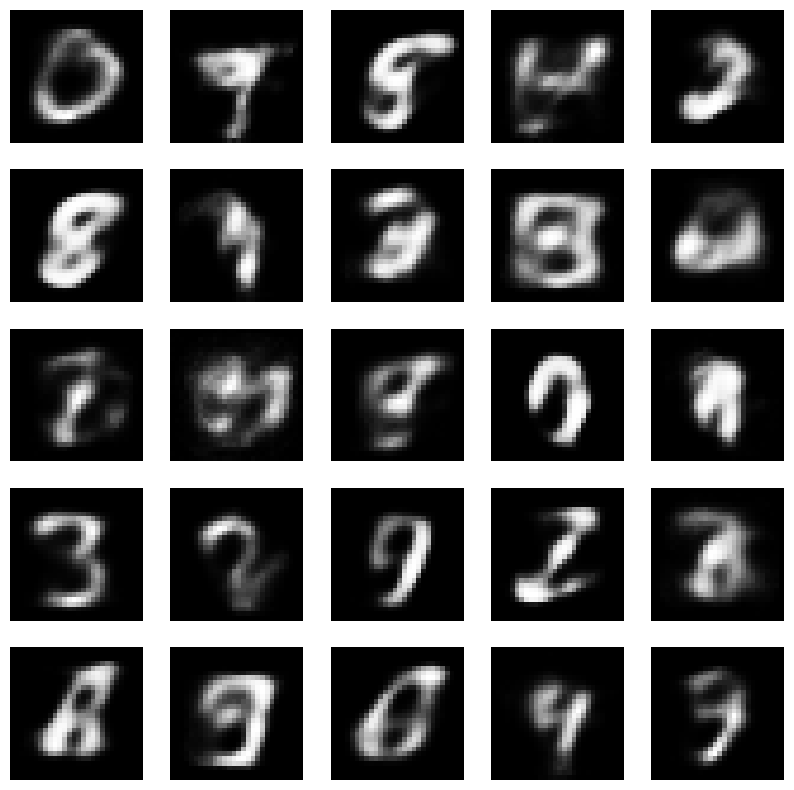

In [17]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
plt.gray()
for i in range(25):
  idx = divmod(i, 5)
  ax[idx].imshow(out[i])
  ax[idx].axis('off');   
fig.show()